In [7]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from matplotlib import colors, ticker

from fibrosisanalysis.parsers.stats_loader import StatsLoader
from fibrosisanalysis.slice.heart_slice import HeartSliceBuilder
from fibrosisanalysis.analysis import (
    ObjectsPropertiesBuilder,
    SegmentsPropertiesBuilder
)

from tqdm.notebook import tqdm


def collect_data(path, hearts, n_radial, n_angular, node_step):
    collected_data = [[], []]
    
    for heart in hearts:
        path_ = path.joinpath(heart, 'Stats')
        files = list(path_.glob('*{}'.format('.pkl')))
        files = sorted([file.stem for file in files if not file.name.startswith('.')])
    
        for slice_name in tqdm(files):
            # Load slice and build HeartSlice object
            heart_slice_builder = HeartSliceBuilder()
            heart_slice_builder.build_from_file(path, heart, slice_name,
                                                n_angular, n_radial, node_step)
            heart_slice = heart_slice_builder.heart_slice
    
            # Load stats
            for i, subdir in enumerate(['Stats', 'StatsGenerated']):
            # for i, subdir in enumerate(['Stats']):
                path_slice_stats = path.joinpath(heart, subdir, slice_name)
                stats_loader = StatsLoader(path, collected_columns=['centroid-0',
                                                                    'centroid-1',
                                                                    'major_axis_length',
                                                                    'minor_axis_length',
                                                                    'orientation',
                                                                    'area',
                                                                    'density'])
                object_stats = stats_loader.load_slice_data(path_slice_stats)
        
                # Build objects properties
                objects_props_builder = ObjectsPropertiesBuilder()
                objects_props_builder.build_from_stats(object_stats)
                objects_props_builder.add_slice_props(heart_slice)
                objects_props = objects_props_builder.objects_props
                objects_props = objects_props.loc[:, ['segment_labels',
                                                      'relative_orientation',
                                                      'axis_ratio',
                                                      'area', 'density']]
        
                objects_props['location'] = pd.cut(objects_props['segment_labels'],
                                                   bins=np.linspace(0, n_angular * n_radial,
                                                                    n_radial + 1),
                                                   labels=['SUB-ENDO', 'MID', 'SUB-EPI'])
                objects_props['heart'] = heart
        
                collected_data[i].append(objects_props)
    
    df = pd.concat(collected_data[0], ignore_index=True)
    df_gen = pd.concat(collected_data[1], ignore_index=True)
    return df, df_gen

In [8]:
# path = Path('/home/arstan/Projects/Fibrosis/FibrosisAnalysis/data')
path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')
path_stats = path

hearts = ['E10691_RBM20', 'E11444_LMNA', 'E10927_MYBPC3']

# hearts = ['E10691_RBM20',
#           'E11442_TTN',
#           'E10621_ABCC9',
#           'E11444_LMNA',
#           'E10615_MYH7',
#           'E11443_LMNA',
#           'E11971_MYH7',
#           'E10927_MYBPC3',
#           'E10884',
#           'E10788_LMNA']

n_radial = 3
n_angular = 12
node_step = 3

data, data_gen = collect_data(path, hearts, n_radial, n_angular, node_step)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [22]:
data.head()

,segment_labels,relative_orientation,axis_ratio,area,density,location,heart,orientation
0,0,1.178501,5.478154,490,0.176062,NaN,1,67.523132
1,0,1.363462,5.490197,48,0.156536,NaN,1,78.120592
2,31,-1.084195,6.695869,40,0.216471,SUB-EPI,1,-62.119784
3,0,-1.385318,1.637046,10,0.137647,NaN,1,-79.372855
4,31,-0.423936,1.414583,1623,0.343411,SUB-EPI,1,-24.289735


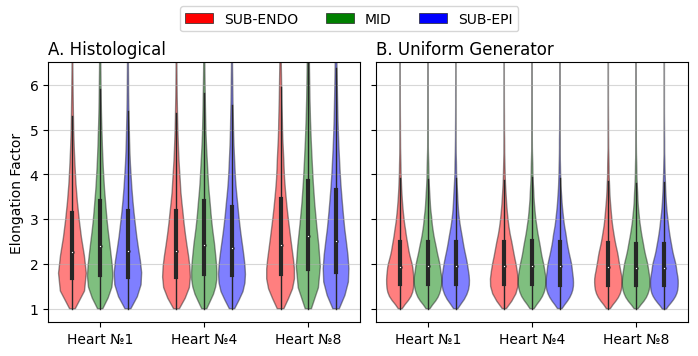

In [21]:
import seaborn as sns
import matplotlib.patches as mpatches

titles = ['A', 'B', 'C']
heart_labels = [f'Heart №{i}' for i in [1, 4, 8]]
COLORS = {'SUB-ENDO': 'r', 'MID': 'g', 'SUB-EPI': 'b'}

fig, axs = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)

for i in range(2):
    df = (data, data_gen)[i]
    ax = axs[i]
    sns.violinplot(data=df, y='axis_ratio', x='heart', hue='location', 
                ax=ax, palette=COLORS, alpha=0.5, saturation=1,
                linewidth=1, legend=False, cut=0, density_norm='area',
                bw_methods='silverman')


    for violin in ax.collections[::2]:
        violin.set_alpha(0.5)
        
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels())
    ax.set_ylim(0.7, 6.5)

    ax.set_xticklabels(heart_labels, fontsize=10)
    # plt.xticks(rotation=45)

    ax.legend_.remove()

    ax.grid(axis='y', linestyle='-', alpha=0.5)
    ax.set_ylabel('', fontsize=10)

axs[0].set_title('A. Histological', fontsize=12, loc='left')
axs[1].set_title('B. Uniform Generator', fontsize=12, loc='left')

axs[0].set_ylabel('Elongation Factor', fontsize=10)
fig.legend(handles=axs[0].get_legend_handles_labels()[0],
           labels=axs[0].get_legend_handles_labels()[1],
           loc='upper center', ncol=3, prop={'size': 10})
# fig.legend(loc='upper center', ncol=3, prop={'size': 10})
plt.subplots_adjust(top=0.85,
                    bottom=0.2,
                    left=0.1,
                    right=0.9,
                    hspace=0.1,
                    wspace=0.05)
plt.show()

In [22]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('axis_ratio.png'),
            dpi=300, bbox_inches='tight')

/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

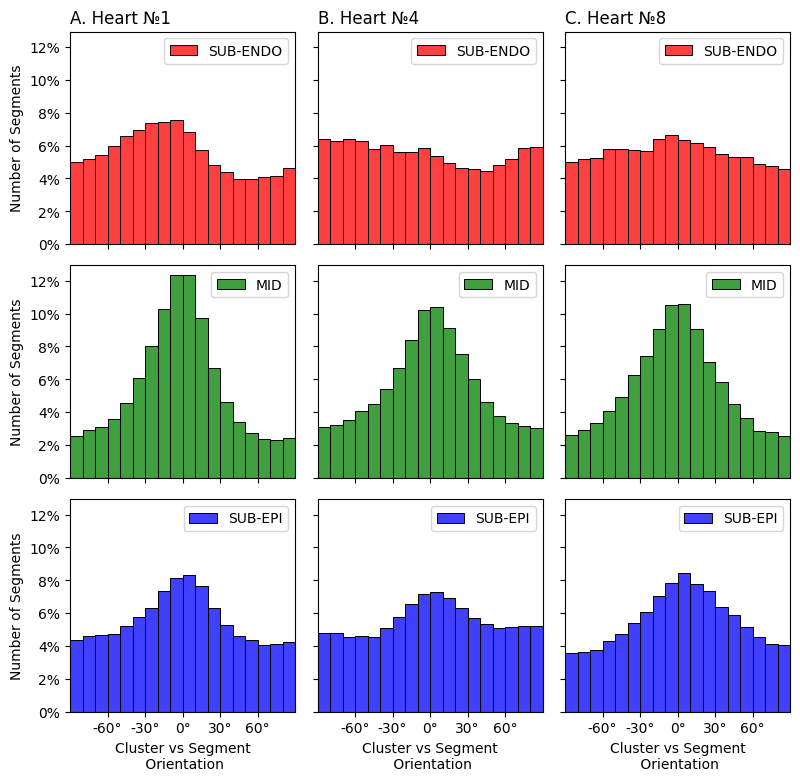

In [4]:
def degrees_formatter(x, pos):
    return f'{x * 180 / np.pi:.0f}°'


titles = ['A', 'B', 'C']
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(8, 8),
                        sharey=True, sharex=True)

for i, heart in enumerate(hearts):
    axs[0, i].set_title(f'{titles[i]}. {heart_labels[i]}',
                        fontsize=12, loc='left')
    axs[-1, i].set_xlabel('Cluster vs Segment\n Orientation', fontsize=10)
    axs[i, 0].set_ylabel('Number of Segments', fontsize=10)

    for j, location in enumerate(['SUB-ENDO', 'MID', 'SUB-EPI']):

        ax = axs[j, i]

        df = data[(data['heart'] == heart) & (data['location'] == location)]
        sns.histplot(x=df['relative_orientation'].values,
                     bins=np.linspace(-90, 90, 19) / 180 * np.pi, 
                     ax=ax, color=COLORS[location], stat='percent')
        ax.legend([location], loc='upper right', fontsize=10)
        ax.set_xlim([-np.pi/2, np.pi/2])
        # ax.set_title(f'{heart}-{location}')
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(degrees_formatter))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100,
                                                             decimals=0))
         
        # ax.set_yticks([0, 10, 20, 30])
        ax.set_xticks(np.arange(-60, 70, 30) / 180 * np.pi)
        # ax.set_ylabel('')
    


plt.subplots_adjust(top=0.9, 
                    bottom=0.05, 
                    left=0.05, 
                    right=0.95, 
                    hspace=0.1,
                    wspace=0.1)
# fig.legend(handles=[mpatches.Patch(color=COLORS[l], 
#                                    label=l) for l in ['SUB-ENDO', 'MID', 
#                                                       'SUB-EPI']],
        #    loc='upper center', ncol=3, prop={'size': 10})
plt.show()

In [6]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('clusters_orientation.png'),
            dpi=300, bbox_inches='tight')

In [18]:
heart_order = ['E10691_RBM20',
               'E11442_TTN',
               'E10621_ABCC9',
               'E11444_LMNA', 
               'E10615_MYH7',
               'E11443_LMNA',
               'E11971_MYH7', 
               'E10927_MYBPC3',
               'E10884',
               'E10788_LMNA']

# heart_order = dict(zip(heart_order, range(1, 1 + len(heart_order))))

df['orientation'] = df['relative_orientation'].apply(np.degrees)
df['heart'] = df['heart'].replace(heart_order,
                                  range(1, 1 + len(heart_order)))

grouped = df.groupby(['heart', 'location'], observed=True)
descrb = grouped['orientation'].describe()

res = descrb.applymap('{:.2f}'.format)
res['count'] = res['count'].apply(float).astype(int)
# res['heart'] = res['heart'].replace(heart_order, range(1, 1 + len(heart_order)))
res

/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_5763/1220988921.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['heart'] = df['heart'].replace(heart_order,
/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_5763/1220988921.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  res = descrb.applymap('{:.2f}'.format)


count   mean    std     min     25%     50%    75%    max
heart location                                                           
1     SUB-ENDO  60533  -6.02  48.54  -90.00  -44.77   -9.84  30.51  90.00
      MID       77364  -2.96  38.72  -89.99  -26.99   -2.57  19.46  90.00
      SUB-EPI   56271  -1.46  46.99  -90.00  -37.45   -1.31  32.82  90.00
2     SUB-ENDO  39632  -2.83  45.37  -89.98  -36.25   -3.72  29.45  90.00
      MID       55652  -0.27  39.79  -90.00  -25.47   -0.43  25.18  90.00
      SUB-EPI   48676   2.86  41.72  -90.00  -23.46    3.66  31.19  90.00
3     SUB-ENDO  27401  -2.36  52.52  -90.00  -47.75   -4.95  43.17  90.00
      MID       47023  -1.47  43.27  -90.00  -30.69   -1.01  26.89  90.00
      SUB-EPI   45207   1.24  43.87  -90.00  -28.39    1.62  31.16  90.00
4     SUB-ENDO  34113  -3.79  53.12  -89.99  -50.65   -7.19  42.87  90.00
      MID       43321   0.25  42.26  -90.00  -28.04    0.88  28.43  90.00
      SUB-EPI   40808   2.02  49.28  -89.99  -36.72    3.01  41.70  90.00
5     SUB-ENDO  37539  -6.74  49.34  -90.00  -47.34  -10.36  30.70  89.99
      MID       62843  -2.58  40.64  -90.00  -28.97   -2.71  22.49  90.00
      SUB-EPI   64242   1.21  46.78  -90.00  -33.24    3.18  35.10  90.00
6     SUB-ENDO  19238  -3.12  46.15  -90.00  -38.15   -4.94  30.40  89.99
      MID       27563  -1.04  40.48  -90.00  -27.04   -1.55  24.73  90.00
      SUB-EPI   27014  -0.99  46.74  -89.98  -36.21   -1.18  33.65  90.00
7     SUB-ENDO  27788  -3.64  50.90  -90.00  -46.05   -7.56  39.22  89.99
      MID       46804  -0.78  37.48  -89.96  -23.06   -0.46  21.42  89.99
      SUB-EPI   49937   0.28  44.37  -90.00  -30.75    0.66  31.18  89.99
8     SUB-ENDO  24929  -1.51  49.81  -89.99  -43.16   -2.16  39.61  89.99
      MID       28564  -1.08  40.78  -89.98  -28.74   -1.11  25.65  89.96
      SUB-EPI   38210   3.07  45.82  -90.00  -30.62    4.48  38.09  89.98
9     SUB-ENDO  17569  -2.62  53.58  -90.00  -50.34   -5.04  45.15  90.00
      MID       36590  -5.20  43.88  -90.00  -37.45   -6.46  24.18  89.99
      SUB-EPI   52075   2.87  42.88  -90.00  -25.25    3.93  32.69  89.99
10    SUB-ENDO   6309  -4.54  50.86  -89.89  -46.62   -9.81  37.03  89.99
      MID       10630  -0.44  42.02  -89.97  -29.12    0.21  27.08  89.91
      SUB-EPI   15493  -0.41  49.87  -90.00  -41.12   -0.35  40.74  90.00

In [7]:
heart_order = ['E10691_RBM20',
               'E11442_TTN',
               'E10621_ABCC9',
               'E11444_LMNA', 
               'E10615_MYH7',
               'E11443_LMNA',
               'E11971_MYH7', 
               'E10927_MYBPC3',
               'E10884',
               'E10788_LMNA']

# heart_order = dict(zip(heart_order, range(1, 1 + len(heart_order))))

df['heart'] = df['heart'].replace(heart_order,
                                  range(1, 1 + len(heart_order)))

grouped = df.groupby(['heart', 'location'], observed=True)
descrb = grouped['axis_ratio'].describe()

res = descrb.applymap('{:.2f}'.format)
res['count'] = res['count'].apply(float).astype(int)
# res['heart'] = res['heart'].replace(heart_order, range(1, 1 + len(heart_order)))
res

count  mean   std   min   25%   50%   75%    max
heart location                                                  
1     SUB-ENDO  60533  2.63  1.42  1.00  1.70  2.26  3.14  40.35
      MID       77364  2.82  1.55  1.00  1.76  2.40  3.42  24.99
      SUB-EPI   56271  2.68  1.49  1.00  1.71  2.28  3.19  27.66
2     SUB-ENDO  39632  2.85  1.57  1.00  1.79  2.43  3.43  26.30
      MID       55652  2.88  1.52  1.00  1.82  2.48  3.50  34.05
      SUB-EPI   48676  2.90  1.60  1.00  1.81  2.47  3.49  26.00
3     SUB-ENDO  27401  2.82  1.59  1.00  1.77  2.40  3.38  32.97
      MID       47023  2.89  1.56  1.00  1.80  2.47  3.50  23.42
      SUB-EPI   45207  2.78  1.55  1.00  1.75  2.38  3.35  27.69
4     SUB-ENDO  34113  2.63  1.33  1.00  1.71  2.29  3.18  24.41
      MID       43321  2.78  1.39  1.00  1.79  2.43  3.40  17.09
      SUB-EPI   40808  2.71  1.37  1.00  1.75  2.35  3.26  20.04
5     SUB-ENDO  37539  2.66  1.44  1.00  1.71  2.28  3.16  41.34
      MID       62843  2.75  1.41  1.00  1.75  2.38  3.32  17.52
      SUB-EPI   64242  2.70  1.44  1.00  1.73  2.33  3.24  38.65
6     SUB-ENDO  19238  2.62  1.38  1.00  1.70  2.26  3.12  35.34
      MID       27563  2.81  1.46  1.00  1.79  2.42  3.42  17.02
      SUB-EPI   27014  2.70  1.42  1.00  1.73  2.33  3.23  24.05
7     SUB-ENDO  27788  2.60  1.34  1.00  1.70  2.25  3.10  24.44
      MID       46804  2.95  1.60  1.00  1.82  2.52  3.61  24.41
      SUB-EPI   49937  2.68  1.43  1.00  1.73  2.31  3.22  32.09
8     SUB-ENDO  24929  2.87  1.61  1.00  1.77  2.42  3.45  23.02
      MID       28564  3.15  1.90  1.00  1.88  2.63  3.86  47.51
      SUB-EPI   38210  3.01  1.79  1.00  1.82  2.52  3.64  30.63
9     SUB-ENDO  17569  2.67  1.42  1.00  1.72  2.31  3.18  25.59
      MID       36590  2.67  1.32  1.00  1.74  2.33  3.23  19.47
      SUB-EPI   52075  2.72  1.45  1.00  1.73  2.34  3.27  23.91
10    SUB-ENDO   6309  2.51  1.31  1.00  1.66  2.19  2.97  27.17
      MID       10630  2.76  1.45  1.00  1.75  2.38  3.37  16.38
      SUB-EPI   15493  2.63  1.36  1.00  1.71  2.28  3.16  23.04

/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

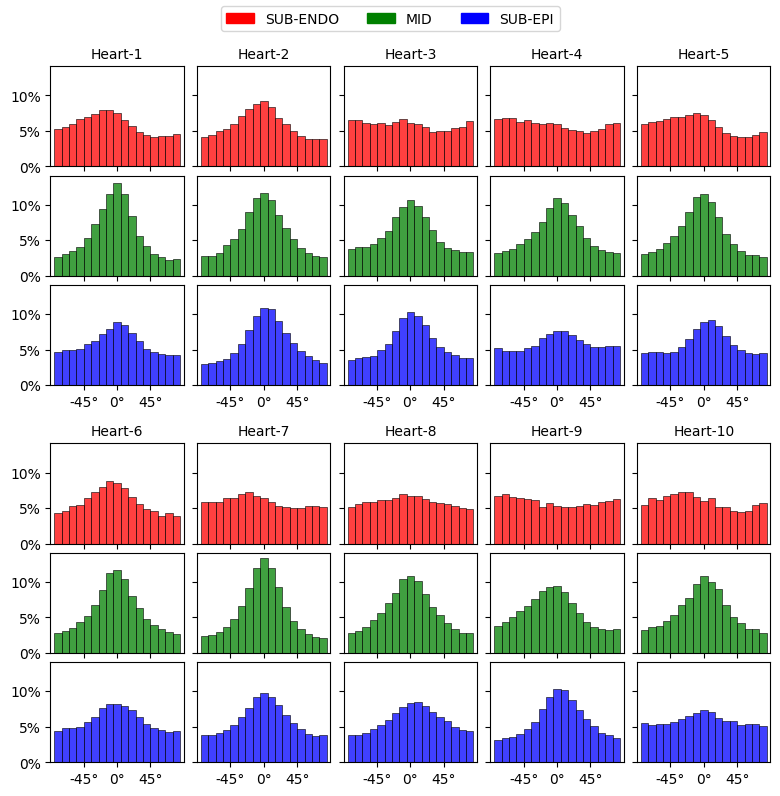

In [52]:
def degrees_formatter(x, pos):
    return f'{x * 180 / np.pi:.0f}°'


fig, axs = plt.subplots(ncols=5, nrows=7, figsize=(8, 8),
                        sharey=True, 
                        height_ratios=[1, 1, 1, 0.4, 1, 1, 1])

for i, heart in enumerate(heart_labels[:]):
    axs[4 * (i // 5), i % 5].set_title(heart, fontsize=10)

    for j, location in enumerate(['SUB-ENDO', 'MID', 'SUB-EPI']):

        if i >= 5:
            ax = axs[j + 4, i % 5]
        else:
            ax = axs[j, i]

        ddf = data[(data['heart'] == i+1) & (data['location'] == location)]
        sns.histplot(x=ddf['relative_orientation'].values,
                     bins=np.arange(-85, 95, 10) / 180 * np.pi, 
                     ax=ax, color=COLORS[location], stat='percent')
        ax.set_xlim([-np.pi/2, np.pi/2])
        # ax.set_title(f'{heart}-{location}')
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(degrees_formatter))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100,
                                                             decimals=0))
         
        ax.set_yticks([0, 5, 10])
        ax.set_xticks([-np.pi/4, 0, np.pi/4])
        ax.set_ylabel('')

for i in range(5):
    axs[3, i].axis('off')
    for j in [0, 1, 4, 5]:
        axs[j, i].set_xticklabels([])

plt.subplots_adjust(top=0.92, 
                    bottom=0.05, 
                    left=0.05, 
                    right=0.95, 
                    hspace=0.1,
                    wspace=0.1)
fig.legend(handles=[mpatches.Patch(color=COLORS[l], 
                                   label=l) for l in ['SUB-ENDO', 'MID', 
                                                      'SUB-EPI']],
           loc='upper center', ncol=3, prop={'size': 10})
plt.show()

In [53]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('orientation.png'),
            dpi=300, bbox_inches='tight')

### Elongation

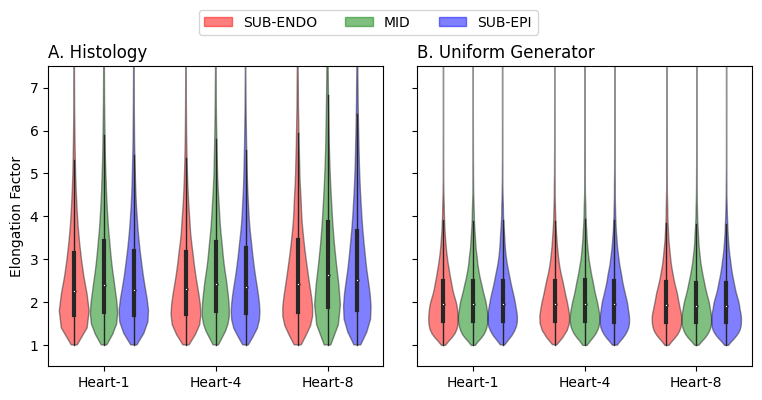

In [3]:
import seaborn as sns
import matplotlib.patches as mpatches

COLORS = {'SUB-ENDO': 'r', 'MID': 'g', 'SUB-EPI': 'b'}

fig, axs = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)

for ddf, ax in zip([df, df_gen], axs):
    sns.violinplot(data=ddf, y='axis_ratio', x='heart', hue='location', 
                   ax=ax, palette=COLORS, alpha=0.5, saturation=1,
                  linewidth=1, legend=False, cut=0)


for ax in axs:
    for violin in ax.collections[::2]:
        violin.set_alpha(0.5)
    ax.set_xticks(ticks=[0, 1, 2], labels=['Heart-1', 'Heart-4', 'Heart-8'])
    ax.set_xlabel('')

    ax.set_ylim(0.5, 7.5)
    ax.get_legend().remove()
axs[1].set_ylabel('')
axs[0].set_ylabel('Elongation Factor')

plt.subplots_adjust(top=0.85, bottom=0.1, right=0.98, left=0.1,
                    wspace=0.1, hspace=0.2)

legends = [mpatches.Patch(color=color, label=label,
                          alpha=0.5) for label, color in COLORS.items()]
fig.legend(handles=legends, labels=list(COLORS.keys()), loc='center',
           bbox_to_anchor=(0.5, 0.96), ncol=3)
# fig.legend(handles=bar_gen.patches[:1] + bar.patches[:1],
#            labels=['Uniform generator', 'Histology'], loc='center',
#            bbox_to_anchor=(0.5, 0.96), ncol=2)
axs[0].set_title('A. Histology', loc='left')
axs[1].set_title('B. Uniform Generator', loc='left')
plt.show()

In [4]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('axis_ratio.png'),
            dpi=300, bbox_inches='tight')

In [115]:
grouped = df_gen.groupby(['heart', 'location'], observed=True)
grouped['axis_ratio'].describe()

count      mean       std       min       25%  \
heart         location                                                    
E10691_RBM20  SUB-ENDO  43572.0  2.112152  0.771067  1.000000  1.546028   
              MID       42764.0  2.119858  0.783533  1.000000  1.552786   
              SUB-EPI   26394.0  2.114921  0.766919  1.000000  1.552011   
E10927_MYBPC3 SUB-ENDO  43611.0  2.093616  0.760115  1.000000  1.538261   
              MID       58489.0  2.074574  0.738599  1.001837  1.530629   
              SUB-EPI   60110.0  2.077907  0.747669  1.000000  1.528277   
E11444_LMNA   SUB-ENDO  38555.0  2.108122  0.766516  1.004796  1.549672   
              MID       32350.0  2.123689  0.784082  1.000000  1.553101   
              SUB-EPI   24572.0  2.105220  0.759022  1.004988  1.542345   

                             50%       75%        max  
heart         location                                 
E10691_RBM20  SUB-ENDO  1.943963  2.496595  10.148495  
              MID       1.948644  2.491018   9.469669  
              SUB-EPI   1.952163  2.494479  11.489125  
E10927_MYBPC3 SUB-ENDO  1.927998  2.462107   9.281975  
              MID       1.916600  2.444283   9.281975  
              SUB-EPI   1.915523  2.447636   8.136683  
E11444_LMNA   SUB-ENDO  1.945455  2.481833  17.372327  
              MID       1.952151  2.505362  10.148495  
              SUB-EPI   1.945994  2.495178   9.281975

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113599 entries, 0 to 113598
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   segment_labels        113599 non-null  int64   
 1   relative_orientation  113599 non-null  float64 
 2   axis_ratio            113599 non-null  float64 
 3   area                  113599 non-null  int64   
 4   density               113599 non-null  float64 
 5   location              113434 non-null  category
 6   heart                 113599 non-null  int64   
dtypes: category(1), float64(3), int64(3)
memory usage: 5.3 MB


In [132]:
grouped = df.groupby(['heart', 'location'], observed=True)
grouped['relative_orientation'].describe()

count      mean       std       min       25%  \
heart         location                                                    
E10691_RBM20  SUB-ENDO  60525.0 -0.106220  0.845081 -1.570784 -0.781425   
              MID       77345.0 -0.051019  0.675346 -1.570678 -0.470271   
              SUB-EPI   55844.0 -0.025309  0.820606 -1.570780 -0.654581   
E10927_MYBPC3 SUB-ENDO  24848.0 -0.020822  0.869688 -1.570457 -0.748082   
              MID       28573.0 -0.018454  0.711428 -1.570698 -0.498624   
              SUB-EPI   38058.0  0.054356  0.799535 -1.570704 -0.533492   
E11444_LMNA   SUB-ENDO  34026.0 -0.065898  0.926751 -1.570730 -0.881197   
              MID       43254.0  0.003792  0.736936 -1.570792 -0.488526   
              SUB-EPI   40524.0  0.033861  0.859528 -1.570707 -0.641514   

                             50%       75%       max  
heart         location                                
E10691_RBM20  SUB-ENDO -0.173006  0.528399  1.570602  
              MID      -0.044195  0.340106  1.570751  
              SUB-EPI  -0.022618  0.573735  1.570678  
E10927_MYBPC3 SUB-ENDO -0.031257  0.696356  1.570668  
              MID      -0.017653  0.447560  1.570622  
              SUB-EPI   0.080571  0.665077  1.570394  
E11444_LMNA   SUB-ENDO -0.126071  0.748027  1.570761  
              MID       0.013096  0.494562  1.570286  
              SUB-EPI   0.050411  0.725165  1.570746

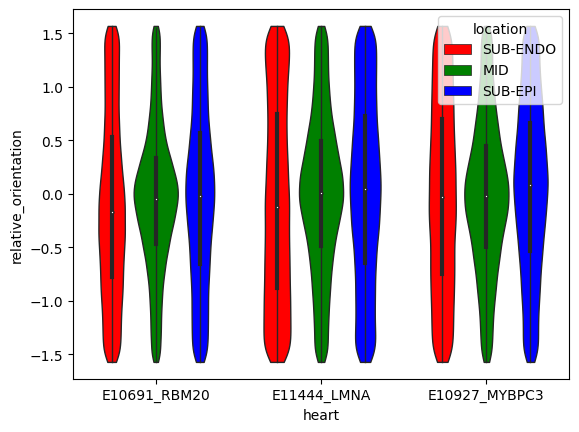

In [11]:
fig, ax = plt.subplots()
sns.violinplot(data=df, y='relative_orientation', x='heart', hue='location', 
               ax=ax, palette=COLORS, alpha=0.5, saturation=1,
               linewidth=1, legend=False, cut=0)
plt.show()

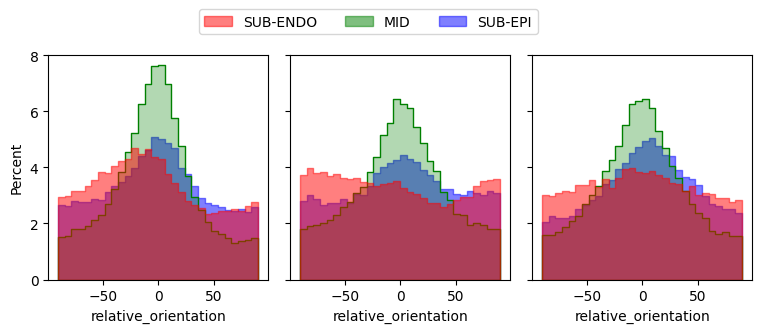

In [39]:
fig, axs = plt.subplots(ncols=3, figsize=(8, 3), sharex=True, sharey=True)

for i, (heart, _) in enumerate(hearts.items()):
    ddf = df[df['heart'] == heart]
    
    x = ddf['relative_orientation'].apply(np.degrees)

    sns.histplot(data=ddf, x=x, hue='location', element="step",
                 bins=np.linspace(-90, 90, 31), palette=COLORS, alpha=0.3,
                 ax=axs[i], linewidth=1, stat='percent', common_norm=False)
    

for ax in axs:
    for hist in ax.collections[::2]:
        hist.set_alpha(0.5)
#     ax.set_xticks(ticks=[0, 1, 2], labels=['Heart-1', 'Heart-4', 'Heart-8'])
#     ax.set_xlabel('')

#     ax.set_ylim(0.5, 7.5)
    ax.get_legend().remove()
axs[1].set_ylabel('')
# axs[0].set_ylabel('Elongation Factor')

plt.subplots_adjust(top=0.85, bottom=0.1, right=0.98, left=0.1,
                    wspace=0.1, hspace=0.2)

legends = [mpatches.Patch(color=color, label=label,
                          alpha=0.5) for label, color in COLORS.items()]
fig.legend(handles=legends, labels=list(COLORS.keys()), loc='center',
           bbox_to_anchor=(0.5, 0.96), ncol=3)
plt.show()

In [29]:
df.groupby(['heart', 'location'])['relative_orientation'].describe()


count      mean       std       min       25%  \
heart         location                                                    
E10691_RBM20  SUB-ENDO  60525.0 -0.106220  0.845081 -1.570784 -0.781425   
              MID       77345.0 -0.051019  0.675346 -1.570678 -0.470271   
              SUB-EPI   55844.0 -0.025309  0.820606 -1.570780 -0.654581   
E10927_MYBPC3 SUB-ENDO  24848.0 -0.020822  0.869688 -1.570457 -0.748082   
              MID       28573.0 -0.018454  0.711428 -1.570698 -0.498624   
              SUB-EPI   38058.0  0.054356  0.799535 -1.570704 -0.533492   
E11444_LMNA   SUB-ENDO  34026.0 -0.065898  0.926751 -1.570730 -0.881197   
              MID       43254.0  0.003792  0.736936 -1.570792 -0.488526   
              SUB-EPI   40524.0  0.033861  0.859528 -1.570707 -0.641514   

                             50%       75%       max  
heart         location                                
E10691_RBM20  SUB-ENDO -0.173006  0.528399  1.570602  
              MID      -0.044195  0.340106  1.570751  
              SUB-EPI  -0.022618  0.573735  1.570678  
E10927_MYBPC3 SUB-ENDO -0.031257  0.696356  1.570668  
              MID      -0.017653  0.447560  1.570622  
              SUB-EPI   0.080571  0.665077  1.570394  
E11444_LMNA   SUB-ENDO -0.126071  0.748027  1.570761  
              MID       0.013096  0.494562  1.570286  
              SUB-EPI   0.050411  0.725165  1.570746